# EXPLORATORY DATA ANALYSIS AND VISUALIZATION 

In this notebook, we will perform Exploratory Data Analysis (EDA) on our dataset to gain insights and understanding of the underlying patterns, relationships, and distributions within the data. EDA is a crucial step in the data analysis process as it helps us to uncover key characteristics of the dataset, identify any anomalies or missing values, and formulate hypotheses for further analysis. By utilizing various statistical and visualization techniques, we aim to explore the structure and content of the data, as well as to identify potential trends or correlations that may exist. Through visualization, we will represent the data in graphical form, allowing us to intuitively interpret complex patterns and trends that may not be immediately apparent from raw data. Overall, the goal of this exploratory phase is to lay the foundation for subsequent modeling and analysis, guiding us towards actionable insights and informed decision-making.


 ## Import Libraries
 

In [1]:
#!pip install geopandas
#!pip install seaborn
#!pip install folium
#!pip install plotly
#!pip install ipywidgets

In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
import numpy as np
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from ipywidgets import interact, IntSlider
from branca.colormap import LinearColormap

## Helper Function

In [4]:
def calculate_mean(dataframe, group_by_columns, average_columns, additional_columns=None):
    
    '''
    Aggregate data in a DataFrame by specified columns and calculate the mean of one or more columns.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data to be aggregated.
    - group_by_columns (list): The list of column names to group the data by.
    - average_columns (list): A list of column names to calculate the average.
    - additional_columns (list, optional): A list of column names to include in the output DataFrame.

    Returns:
    pd.DataFrame: A new DataFrame containing the aggregated results with the following columns:
        - [average_columns]: The average values of the specified average_columns.
        - Count: The count of rows used to calculate the mean values.
        - Additional_columns (optional): The values of the specified additional_columns if provided.
    '''

    # Group by the specified columns and calculate the mean for each average column
    aggregated_data = dataframe.groupby(group_by_columns)[average_columns].mean().reset_index()
    # Round the mean values to 2 decimal points
    aggregated_data[average_columns] = aggregated_data[average_columns].round(2)

    # Calculate the count based on the first average column
    count_column = dataframe.groupby(group_by_columns)[average_columns[0]].count().reset_index()
    # Rename the count column
    count_column.rename(columns={average_columns[0]: 'count'}, inplace=True)

    # Merge the count column with the aggregated data
    aggregated_data = pd.merge(aggregated_data, count_column, on=group_by_columns)

    # If additional columns are specified, merge them into the aggregated DataFrame
    if additional_columns:
        for additional_column in additional_columns:
            additional_df = dataframe[group_by_columns + [additional_column]].drop_duplicates()
            aggregated_data = pd.merge(additional_df, aggregated_data, on=group_by_columns)

    # Reorder columns so that additional columns appear first
    if additional_columns:
        columns_order = group_by_columns + additional_columns + average_columns + ['count']
        aggregated_data = aggregated_data[columns_order]

    return aggregated_data

In [9]:
def calculate_fcs_percentages(dataframe):
    
    # Calculate the number of households falling into each category
    poor_count = len(dataframe[dataframe['fcs'] <= 21])
    borderline_count = len(dataframe[(dataframe['fcs'] > 21) & (dataframe['fcs'] <= 35)])
    acceptance_count = len(dataframe[dataframe['fcs'] > 35])

    # Calculate percentages
    total_households = len(dataframe)
    poor_percentage = (poor_count / total_households) * 100
    borderline_percentage = (borderline_count / total_households) * 100
    acceptance_percentage = (acceptance_count / total_households) * 100

    # Display percentages
    print("Percentage of households with 'poor' FCS:", poor_percentage)
    print("Percentage of households with 'borderline' FCS:", borderline_percentage)
    print("Percentage of households with 'acceptance' FCS:", acceptance_percentage)

    # Plot pie chart
    labels = ['Poor', 'Borderline', 'Acceptance']
    sizes = [poor_percentage, borderline_percentage, acceptance_percentage]
    colors = ['red', 'orange', 'green']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Distribution of Food Consumption Score (FCS)')
    plt.show()

## Visualization Functions

In [28]:
# Function to create a histogram
def create_histogram(data, column):
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Function to create a box plot
def create_boxplot(data, numerical_column, categorical_column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=categorical_column, y=numerical_column, data=data)
    plt.title(f'Box plot of {numerical_column} by {categorical_column}')
    plt.xlabel(categorical_column)
    plt.ylabel(numerical_column)
    plt.show()

# Function to create a bar plot
def create_barplot(data, column):
    plt.figure(figsize=(12, 6))
    sns.countplot(x=column, data=data)
    plt.title(f'Count of observations by {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Function to create a scatter plot
def create_scatterplot(data, x_column, y_column):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x_column, y=y_column, data=data)
    plt.title(f'Scatter plot of {x_column} vs {y_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()

# Function to create a pie chart
def create_piechart(data, column):
    plt.figure(figsize=(8, 8))
    data[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
    plt.title(f'Proportion of each {column}')
    plt.ylabel('')
    plt.show()


In [29]:
def create_table_summary(data):
    # Create HTML table
    html_table = "<table style='font-family: Arial, sans-serif; border-collapse: collapse; width: 100%;'>"
    html_table += "<tr style='border: 1px solid #dddddd; text-align: left; padding: 8px; background-color: #f2f2f2;'>"
    html_table += "<th style='border: 1px solid #dddddd; padding: 8px;'>District</th>"
    html_table += "<th style='border: 1px solid #dddddd; padding: 8px;'>FCS</th>"
    html_table += "<th style='border: 1px solid #dddddd; padding: 8px;'>HDDS</th>"
    html_table += "<th style='border: 1px solid #dddddd; padding: 8px;'>Samples</th>"
    html_table += "</tr>"

    # Add data rows
    for index, row in data.iterrows():
        html_table += "<tr style='border: 1px solid #dddddd; text-align: left; padding: 8px;'>"
        html_table += "<td style='border: 1px solid #dddddd; padding: 8px;'>{}</td>".format(row['district'])
        html_table += "<td style='border: 1px solid #dddddd; padding: 8px;'>{}</td>".format(row['fcs'])
        html_table += "<td style='border: 1px solid #dddddd; padding: 8px;'>{}</td>".format(row['hdds'])
        html_table += "<td style='border: 1px solid #dddddd; padding: 8px;'>{}</td>".format(row['count'])
        html_table += "</tr>"
    
    html_table += "</table>"

    return html_table

In [30]:
def create_interactive_map_1(shapefile_df, data_df, join_columns, country_name):
    # Filter shapefile to include only the desired country
    shapefile_df_country = shapefile_df[shapefile_df['country'] == country_name]

    # Join the two dataframes by the specified columns
    combined_df = pd.merge(shapefile_df_country, data_df, on=join_columns)

    # Create a colormap
    colormap = LinearColormap(colors=['red', 'lightcoral', 'green'], vmin=0, vmax=35).to_step(3)

    # Convert colors to hexadecimal strings
    colormap_hex = [colormap(i) for i in range(3)]

    # Create an empty map centered around the centroid of the country
    m = folium.Map(location=[shapefile_df_country.geometry.centroid.y.mean(), shapefile_df_country.geometry.centroid.x.mean()], zoom_start=6, tiles=None)

    # Add choropleth layer
    folium.Choropleth(
        geo_data=combined_df,
        name='choropleth',
        data=combined_df,
        columns=['district', 'fcs'],
        key_on='feature.properties.district',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Food Consumption Score (FCS)',
        highlight=True,
        smooth_factor=0
    ).add_to(m)

    # Add hover functionality
    style_function = lambda x: {'fillColor': colormap(x['properties']['fcs']), 'color': 'black', 'weight': 1, 'fillOpacity': 0.7}
    highlight_function = lambda x: {'fillColor': '#000000', 'color': '#000000', 'weight': 2, 'fillOpacity': 0.7}
    tooltip = folium.features.GeoJsonTooltip(fields=['district', 'fcs', 'hdds', 'count'], aliases=['District', 'FCS', 'HDDS', 'Samples'])
    folium.GeoJson(combined_df, style_function=style_function, highlight_function=highlight_function, tooltip=tooltip).add_to(m)

    # Create HTML table summary
    table_summary_html = create_table_summary(combined_df)

    # Create iframe with map and table side by side
    iframe_html = f"""
        <div style="display: flex;">
            <div style="flex: 1; padding: 10px;">
                <iframe srcdoc="{m._repr_html_()}" style="width: 100%; height: 600px; border: none;"></iframe>
            </div>
            <div style="flex: 1; padding: 10px;">
                {table_summary_html}
            </div>
        </div>
    """

    iframe = folium.IFrame(html=iframe_html, width=800, height=600)
    popup = folium.Popup(iframe, max_width=2650)
    folium.Marker(
        [shapefile_df_country.geometry.centroid.y.mean(), shapefile_df_country.geometry.centroid.x.mean()],
        popup=popup
    ).add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    # Display map
    return m


In [31]:
def create_interactive_map_0(shapefile_df, data_df,join_columns,country_name):
    # Filter shapefile to include only the desired country
    shapefile_df_country = shapefile_df[shapefile_df['country'] == country_name]

    # Join the two dataframes by the specified columns
    combined_df = pd.merge(shapefile_df_country, data_df, on=join_columns)

    # Create an empty map centered around the centroid of the country
    m = folium.Map(location=[shapefile_df_country.geometry.centroid.y.mean(), shapefile_df_country.geometry.centroid.x.mean()], zoom_start=6, tiles=None)

    # Create a colormap
    colormap = LinearColormap(colors=['red', 'lightcoral', 'green'], vmin=0, vmax=35).to_step(3)

    # Convert colors to hexadecimal strings
    colormap_hex = [colormap(i) for i in range(3)]

    # Add choropleth layer
    folium.Choropleth(
        geo_data=combined_df,
        name='choropleth',
        data=combined_df,
        columns=['district', 'fcs'],
        key_on='feature.properties.district',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Food Consumption Score (FCS)',
        highlight=True,
        smooth_factor=0
    ).add_to(m)

    # Add hover functionality
    style_function = lambda x: {'fillColor': colormap(x['properties']['fcs']), 'color': 'black', 'weight': 1, 'fillOpacity': 0.7}
    highlight_function = lambda x: {'fillColor': '#000000', 'color': '#000000', 'weight': 2, 'fillOpacity': 0.7}
    tooltip = folium.features.GeoJsonTooltip(fields=['district', 'fcs', 'hdds', 'count'], aliases=['District', 'FCS', 'HDDS', 'Samples'])
    folium.GeoJson(combined_df, style_function=style_function, highlight_function=highlight_function, tooltip=tooltip).add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    # Display map
    return m


In [32]:
def create_interactive_map2(shapefile_df, data_df, join_columns, country_name):
    # Filter shapefile to include only the desired country
    shapefile_df_country = shapefile_df[shapefile_df['country'] == country_name]

    # Join the two dataframes by the specified columns
    combined_df = pd.merge(shapefile_df_country, data_df, on=join_columns)

    # Create a colormap
    colormap = LinearColormap(colors=['red', 'lightcoral', 'green'], vmin=0, vmax=35).to_step(3)

    # Convert colors to hexadecimal strings
    colormap_hex = [colormap(i) for i in range(3)]

    # Create an empty map centered around the centroid of the country
    m = folium.Map(location=[shapefile_df_country.geometry.centroid.y.mean(), shapefile_df_country.geometry.centroid.x.mean()], zoom_start=6, tiles=None)

    # Add choropleth layer
    folium.Choropleth(
        geo_data=combined_df,
        name='choropleth',
        data=combined_df,
        columns=['district', 'fcs'],
        key_on='feature.properties.district',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Food Consumption Score (FCS)',
        highlight=True,
        smooth_factor=0
    ).add_to(m)

    # Add hover functionality
    style_function = lambda x: {'fillColor': colormap(x['properties']['fcs']), 'color': 'black', 'weight': 1, 'fillOpacity': 0.7}
    highlight_function = lambda x: {'fillColor': '#000000', 'color': '#000000', 'weight': 2, 'fillOpacity': 0.7}
    tooltip = folium.features.GeoJsonTooltip(fields=['district', 'fcs', 'hdds', 'count'], aliases=['District', 'FCS', 'HDDS', 'Samples'])
    folium.GeoJson(combined_df, style_function=style_function, highlight_function=highlight_function, tooltip=tooltip).add_to(m)

    # Create HTML table summary
    table_summary_html = create_table_summary(combined_df)

    # Create iframe with map and table side by side
    iframe_html = f"""
        <div style="display: flex; height: 100vh;">
            <div style="flex: 1; padding: 10px;">
                <iframe srcdoc="{m._repr_html_()}" style="width: 100%; height: 100%; border: none;"></iframe>
            </div>
            <div style="flex: 1; padding: 10px; overflow: auto;">
                {table_summary_html}
            </div>
        </div>
    """

    iframe = folium.IFrame(html=iframe_html, width=800, height=600)
    popup = folium.Popup(iframe, max_width=2650)
    folium.Marker(
        [shapefile_df_country.geometry.centroid.y.mean(), shapefile_df_country.geometry.centroid.x.mean()],
        popup=popup
    ).add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    # Display map
    return m


In [33]:
def create_interactive_map(shapefile_df, data_df, join_columns, country_name):
    # Filter shapefile to include only the desired country
    shapefile_df_country = shapefile_df[shapefile_df['country'] == country_name]

    # Join the two dataframes by the specified columns
    combined_df = pd.merge(shapefile_df_country, data_df, on=join_columns)

    # Create a colormap
    colormap = LinearColormap(colors=['red', 'lightcoral', 'green'], vmin=0, vmax=35).to_step(3)

    # Convert colors to hexadecimal strings
    colormap_hex = [colormap(i) for i in range(3)]

    # Create an empty map centered around the centroid of the country
    m = folium.Map(location=[shapefile_df_country.geometry.centroid.y.mean(), shapefile_df_country.geometry.centroid.x.mean()], zoom_start=6, tiles=None)

    # Add choropleth layer
    folium.Choropleth(
        geo_data=combined_df,
        name='choropleth',
        data=combined_df,
        columns=['district', 'fcs'],
        key_on='feature.properties.district',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Food Consumption Score (FCS)',
        highlight=True,
        smooth_factor=0
    ).add_to(m)

    # Add hover functionality
    style_function = lambda x: {'fillColor': colormap(x['properties']['fcs']), 'color': 'black', 'weight': 1, 'fillOpacity': 0.7}
    highlight_function = lambda x: {'fillColor': '#000000', 'color': '#000000', 'weight': 2, 'fillOpacity': 0.7}
    tooltip = folium.features.GeoJsonTooltip(fields=['district', 'fcs', 'hdds', 'count'], aliases=['District', 'FCS', 'HDDS', 'Samples'])
    folium.GeoJson(combined_df, style_function=style_function, highlight_function=highlight_function, tooltip=tooltip).add_to(m)

    # Create HTML table summary
    table_summary_html = create_table_summary(combined_df)

    # Create iframe with map and table side by side
    iframe_html = f"""
        <div style="display: flex;">
            <div style="flex: 7;">
                <iframe srcdoc="{m._repr_html_()}" style="width: 100%; height: 100vh; border: none;"></iframe>
            </div>
            <div style="flex: 3; overflow: auto;">
                {table_summary_html}
            </div>
        </div>
    """

    iframe = folium.IFrame(html=iframe_html, width=800, height=600)
    popup = folium.Popup(iframe, max_width=2650)
    folium.Marker(
        [shapefile_df_country.geometry.centroid.y.mean(), shapefile_df_country.geometry.centroid.x.mean()],
        popup=popup
    ).add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    # Display map
    return m


## RWANDA

In [223]:
# Load shapefile 
shapefile_df = gpd.read_file('rwanda_data/rwanda_district.gpkg')
shapefile_df.head()

,country,province,district,geometry
0,Rwanda,Amajyaruguru,Burera,"MULTIPOLYGON (((29.80388 -1.56590, 29.80380 -1..."
1,Rwanda,Amajyaruguru,Gakenke,"MULTIPOLYGON (((29.86490 -1.86351, 29.86399 -1..."
2,Rwanda,Amajyaruguru,Gicumbi,"MULTIPOLYGON (((30.27172 -1.81954, 30.27173 -1..."
3,Rwanda,Amajyaruguru,Musanze,"MULTIPOLYGON (((29.66484 -1.59643, 29.66479 -1..."
4,Rwanda,Amajyaruguru,Rulindo,"MULTIPOLYGON (((29.97956 -1.88955, 29.97951 -1..."


In [204]:
#load the data files containing the score
data = pd.read_csv('rwanda_data/rwanda_2006_final.csv')
data.shape

(2777, 7)

In [205]:
#compute the mean of fcs and hdds based on province,district and year
data_df= calculate_mean(data, ['year','province','district'], ['fcs','hdds'], additional_columns=None)
data_df.shape

(29, 6)

In [206]:
combined_df = pd.merge(shapefile_df, data_df, on=['province', 'district'])
combined_df.shape

(29, 8)

In [210]:
# Call the function to create interactive map
map = create_interactive_map(shapefile_df, data_df,['province','district'], country_name = 'Rwanda')
# Save the map to an HTML file
map.save('rwanda_data/interactive_map.html')

C:\Users\ashas\AppData\Local\Temp\ipykernel_25660\1237078756.py:15: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\ashas\AppData\Local\Temp\ipykernel_25660\1237078756.py:56: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [194]:
# Load shapefile and data dataframe
shapefile_df = gpd.read_file('tanzania_data/tanzania_districts.gpkg')
shapefile_df.head()

,country,district,region,geometry
0,Tanzania,Arusha,Arusha,"MULTIPOLYGON (((36.66338 -3.53395, 36.66437 -3..."
1,Tanzania,Arusha Urban,Arusha,"MULTIPOLYGON (((36.72752 -3.48603, 36.72898 -3..."
2,Tanzania,Karatu,Arusha,"MULTIPOLYGON (((35.62337 -3.69765, 35.62201 -3..."
3,Tanzania,Lake Eyasi,Arusha,"MULTIPOLYGON (((35.24703 -3.60927, 35.24533 -3..."
4,Tanzania,Lake Manyara,Arusha,"MULTIPOLYGON (((35.77862 -3.56134, 35.77828 -3..."


In [13]:
data = pd.read_csv('tanzania_data/data/tanzania_2012_2013_final.csv')
data.head()

,hhid,year,region,district,fcs,hdds
0,0001-001,2012,Dodoma,Kondoa,34.5,5
1,0002-001,2012,Dodoma,Kondoa,28.0,5
2,0003-001,2012,Dodoma,Kondoa,54.0,7
3,0003-010,2012,Dar es Salaam,Temeke,62.0,8
4,0005-001,2012,Dodoma,Kondoa,76.0,8


Percentage of households with 'poor' FCS: 4.171656686626746
Percentage of households with 'borderline' FCS: 10.0
Percentage of households with 'acceptance' FCS: 85.82834331337325


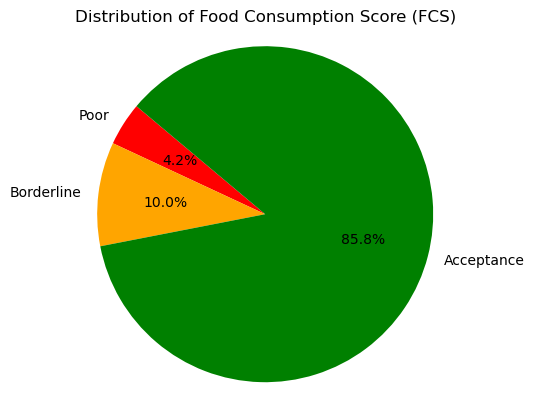

In [14]:
#print the percentages of fcs
calculate_fcs_percentages(data)

In [196]:
data_df= calculate_mean(data, ['year','region','district'], ['fcs','hdds'], additional_columns=None)
data_df.head()

,year,region,district,fcs,hdds,count
0,2008,Arusha,Arusha Urban,36.19,8.88,8
1,2008,Dar es Salaam,Ilala,25.67,7.25,24
2,2008,Dar es Salaam,Kinondoni,26.26,7.23,90
3,2008,Dar es Salaam,Temeke,27.85,7.26,53
4,2008,Dodoma,Dodoma Urban,15.41,6.25,16


In [197]:
data_df.shape

(181, 6)

In [198]:
combined_df = pd.merge(shapefile_df, data_df, on=['region', 'district'])
combined_df.head()

,country,district,region,geometry,year,fcs,hdds,count
0,Tanzania,Arusha,Arusha,"MULTIPOLYGON (((36.66338 -3.53395, 36.66437 -3...",2009,28.00,8.12,8
1,Tanzania,Arusha Urban,Arusha,"MULTIPOLYGON (((36.72752 -3.48603, 36.72898 -3...",2008,36.19,8.88,8
2,Tanzania,Arusha Urban,Arusha,"MULTIPOLYGON (((36.72752 -3.48603, 36.72898 -3...",2009,29.28,7.94,32
3,Tanzania,Karatu,Arusha,"MULTIPOLYGON (((35.62337 -3.69765, 35.62201 -3...",2009,22.16,7.00,16
4,Tanzania,Meru,Arusha,"MULTIPOLYGON (((36.85773 -3.58164, 36.85741 -3...",2009,31.19,8.75,8


In [199]:
combined_df.shape

(181, 8)

In [200]:
combined_df.to_csv('tanzania_data/tanzania_with_shapefile.csv', index=False)

In [201]:
# Call the function to create interactive map
map = create_interactive_map(shapefile_df, data_df,['region','district'],country_name = 'Tanzania')
# Save the map to an HTML file
map.save('tanzania_data/interactive_map.html')

C:\Users\ashas\AppData\Local\Temp\ipykernel_25660\925692254.py:15: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\ashas\AppData\Local\Temp\ipykernel_25660\925692254.py:56: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




### RWANDA DATA VISUALIZATION

### Rwanda 2006

In [34]:
rwanda_all_data = read_csv('rwanda_data/data/rwanda_all_sector.csv',delimiter=',')
rwanda_all_data.head()

,dataset_id,year,hhid,province,district,sector,fcs,hdds
0,1,2006,120303105,Iburasirazuba,Ngoma,Mugesera,75.5,6
1,1,2006,80201303,Iburengerazuba,Rubavu,Cyanzarwe,36.0,3
2,1,2006,60302903,Iburengerazuba,Nyamasheke,Kagano,42.0,3
3,1,2006,121009606,Iburasirazuba,Kirehe,Musaza,61.0,4
4,1,2006,30401901,Amajyepfo,Ruhango,Ruhango,46.0,5


In [35]:
rwanda_all_data = calculate_mean(rwanda_all_data, ['year','province','district','sector'], ['fcs','hdds'])
rwanda_all_data.head(30)

,year,province,district,sector,fcs,hdds,count
0,2006,Amajyaruguru,Burera,Butaro,40.50,4.17,12
1,2006,Amajyaruguru,Burera,Cyanika,32.14,3.14,7
2,2006,Amajyaruguru,Burera,Gatebe,34.17,3.33,3
3,2006,Amajyaruguru,Burera,Gitovu,42.00,3.00,1
4,2006,Amajyaruguru,Burera,Kagogo,35.20,3.40,5
5,2006,Amajyaruguru,Burera,Kinoni,29.08,3.50,6
6,2006,Amajyaruguru,Burera,Kinyababa,30.50,4.00,1
7,2006,Amajyaruguru,Burera,Kivuye,19.62,2.50,4
8,2006,Amajyaruguru,Burera,Rugarama,34.45,4.00,10
9,2006,Amajyaruguru,Burera,Rugengabari,26.17,3.33,3


In [36]:
rwanda_all_data.shape

(1074, 7)

In [37]:
#save the dataset
rwanda_all_data.to_csv('rwanda_data/rwanda_all_data_mean_by_sector.csv', index=False)

In [117]:
tz = read_csv('tanzania_data/tanzania_2020_2021_final.csv',delimiter=',')
tz.head()

,hhid,year,region,district,fcs,hdds
0,1000-001-01,2021,Arusha,Meru,57.0,7
1,1000-001-02,2021,Arusha,Meru,33.0,3
2,1000-001-03,2021,Arusha,Meru,75.0,9
3,1000-001-06,2021,Arusha,Meru,77.0,9
4,1001-001-01,2021,Arusha,Meru,77.0,7


In [118]:
#tz_mean = calculate_mean(tz, ['year','region','district'], ['fcs','hdds'])
tz_mean = calculate_mean(tz, ['year','region'], ['fcs','hdds'])
tz_mean.head()

,year,region,fcs,hdds,count
0,2020,Arusha,58.59,7.64,22
1,2020,Dar es Salaam,54.11,7.26,31
2,2020,Dodoma,51.61,7.22,9
3,2020,Kagera,60.50,7.24,17
4,2020,Kusini Unguja,52.59,6.00,11


In [119]:
tz_mean.shape

(62, 5)

In [120]:
#save the dataset
#tz_mean.to_csv('tanzania_data/tanzania_2020_2021_mean_district.csv', index=False)
#save the dataset
tz_mean.to_csv('tanzania_data/tanzania_2020_2021_mean_region.csv', index=False)

In [131]:
tz = read_csv('tanzania_data/tanzania_2012_2013_final.csv',delimiter=',')
tz.head()

,hhid,year,region,district,fcs,hdds
0,0001-001,2012,Dodoma,Kondoa,34.5,5
1,0002-001,2012,Dodoma,Kondoa,28.0,5
2,0003-001,2012,Dodoma,Kondoa,54.0,7
3,0003-010,2012,Dar es Salaam,Temeke,62.0,8
4,0005-001,2012,Dodoma,Kondoa,76.0,8


In [132]:
tz_mean = calculate_mean(tz, ['year','region'], ['fcs','hdds'])
tz_mean.head()

,year,region,fcs,hdds,count
0,2012,Arusha,63.50,7.88,8
1,2012,Dar es Salaam,65.21,7.95,294
2,2012,Dodoma,45.07,5.79,52
3,2012,Geita,47.26,6.59,17
4,2012,Iringa,57.35,8.46,13


In [133]:
#save the dataset
tz_mean.to_csv('tanzania_data/tanzania_2012_2013_mean_region.csv', index=False)